# Centrality Measures

In [47]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import sqlite3
from matplotlib.patches import Circle
from shapely import Polygon
import numpy as np
from jupedsim.internal.notebook_utils import read_sqlite_file
import plotly.graph_objects as go

%matplotlib inline


from Py.riskSimulationValues import RiskSimulationValues
from Py.dangerSimulation import *
from Py.animation import animate
from Py.simulation_config import SimulationConfig
from Py.agentGroup import AgentGroup
from Py.settingPaths import *
from Py.agent_area_writer import *
import polygons.comparing_algorithms_pol as pol

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

## Choosing the Environment

In [48]:
Environment = pol.get_simple_3x3()
# Environment = pol.get_comparing_algorithms_pol()

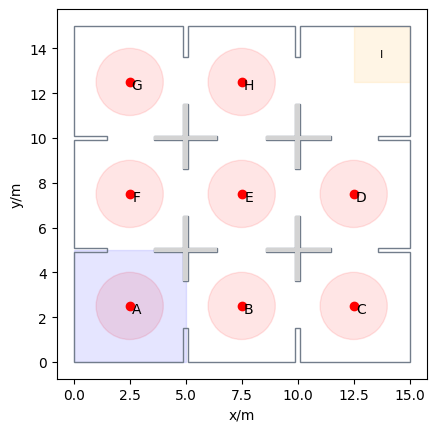

In [49]:
Environment_name = Environment.name
complete_area = Environment.complete_area
obstacles = Environment.obstacles
exit_polygons = Environment.exit_polygons
waypoints = Environment.waypoints
distribution_polygons = Environment.distribution_polygons
obstacle = Environment.obstacles
walkable_area = Environment.walkable_area
G = Environment.G
sources = Environment.sources
targets = Environment.targets
specific_areas = Environment.specific_areas

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(5, -5),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)
for name, exit_polygon in exit_polygons.items():
    x, y = Polygon(exit_polygon).exterior.xy
    plt.fill(x, y, alpha=0.1, color="orange")
    centroid = Polygon(exit_polygon).centroid
    plt.text(centroid.x, centroid.y, f"{name}", ha="center", va="center", fontsize=8)

for name, pol in distribution_polygons.items():
    x, y = pol.exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")

In [50]:
def remove_obstacles_from_areas(specific_areas, obstacles):
    """
    Removes obstacles from specific areas by subtracting overlapping polygons.

    Args:
        specific_areas (dict): Dictionary of named areas {name: Polygon}.
        obstacles (list): List of Polygon objects representing obstacles.

    Returns:
        dict: Dictionary of cleaned areas {name: Polygon without obstacles}.
    """
    cleaned_areas = {}

    for name, area in specific_areas.items():
        # Subtract all obstacles from the current area
        cleaned_area = area
        for obstacle in obstacles:
            if cleaned_area.intersects(obstacle):  # Only process if they overlap
                cleaned_area = cleaned_area.difference(obstacle)

        # Store the cleaned area in the dictionary
        cleaned_areas[name] = cleaned_area

    return cleaned_areas

## Configuration of Simulation Scenarios

In [51]:
# Dictionary to store simulations for different percentages of agents
simulations = {}

# List of modes of algorithms and Knowledge used for the simulation
modes = [0, 1, 2, 3]

# Total number of agents in the simulation (not currently used in this snippet)
total_agents = 10

# Loop over each percentage value to create a corresponding simulation
for mode in modes:
    # Define the output file path for storing the simulation trajectories
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"

    # Create a new simulation instance using JPS (JuPedSim)
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(  # Define the agent movement model
            strength_neighbor_repulsion=2.6,  # Strength of repulsion between neighboring agents
            range_neighbor_repulsion=0.1,  # Distance at which agents start repelling each other
            range_geometry_repulsion=0.05,  # Distance at which agents start avoiding obstacles
        ),
        geometry=walkable_area.polygon,  # Define the walkable area for the simulation
        trajectory_writer=jps.SqliteTrajectoryWriter(  # Specify where to store simulation results
            output_file=pathlib.Path(trajectory_file),  # Save output to the specified SQLite file
        ),
    )

    # Store the simulation object in the dictionary using the percentage as a key
    simulations[mode] = simulation

## Journey configuration

In [52]:
def create_journeys_for_simulation(start, paths, waypoint_ids, exit_ids):
    """
    Generates journey descriptions for simulation agents using the best paths obtained previously.

    Args:
        start (str): The starting node in the graph.
        paths (list): A list of paths (each path is a list of nodes).
        waypoint_ids (dict): A dictionary mapping graph node IDs to simulation waypoint IDs.
        exit_ids (dict): A dictionary mapping exit nodes to simulation exit IDs.

    Returns:
        list: A list of tuples, where each tuple contains:
              - A jps.JourneyDescription object describing the agent's journey.
              - The original path (a list of nodes) used to generate the journey.
    """
    if not paths:
        raise ValueError(f"No valid paths found from {start}.")

    journeys = []
    # Iterate over each path from the best_paths list.
    for path in paths:
        # Skip paths that do not have at least two nodes (start and end are required).
        if len(path) < 2:
            continue

        # Map the intermediate graph nodes to simulation waypoint IDs,
        # excluding the start and end nodes.
        needed_waypoints = [waypoint_ids[node] for node in path[1:-1]]
        if not needed_waypoints:
            continue

        # Ensure that the exit node (last node in the path) exists in the exit_ids dictionary.
        if path[-1] not in exit_ids:
            continue

        # Create a JourneyDescription using the intermediate waypoints and append the exit stage.
        journey = jps.JourneyDescription([*needed_waypoints, exit_ids[path[-1]]])

        # Configure transitions between waypoints.
        for idx, waypoint in enumerate(needed_waypoints):
            # If it's the last waypoint, the next stage is the exit (mapped from exit_ids);
            # otherwise, the next stage is the following waypoint.
            next_waypoint = exit_ids[path[-1]] if idx == len(needed_waypoints) - 1 else needed_waypoints[idx + 1]
            journey.set_transition_for_stage(
                waypoint, jps.Transition.create_fixed_transition(next_waypoint)
            )

        # Append the journey description along with its corresponding path.
        journeys.append((journey, path))

    return journeys

In [53]:
def set_journeys(simulation, start, paths, waypoint_ids, exit_ids):
    """
    Configures agent journeys in the simulation by setting up waypoints, exit stages,
    and journey paths between a start and end point.

    Args:
        simulation (jps.Simulation): The simulation instance where journeys are added.
        start (str): The starting node in the graph.
        end (str): The destination node in the graph.
        paths (list): A list of paths (each path is a list of nodes).
        waypoint_ids (dict): A dictionary mapping nodes to waypoint IDs in the simulation.
        exit_ids (dict): A dictionary mapping exit nodes to simulation exit IDs.

    Returns:
        tuple:
            - journeys_id (dict): A dictionary mapping the starting node to a list of tuples (journey ID, path) for each journey.
    """

    # Generate different journey paths using the provided graph information
    journeys = create_journeys_for_simulation(start, paths, waypoint_ids, exit_ids)

    # Initialize a dictionary to store journey IDs and their associated paths
    journeys_id = {}

    # Iterate over the generated journeys and their respective paths
    for journey, path in journeys:
        # Add the journey to the simulation and retrieve its unique ID
        journey_id = simulation.add_journey(journey)

        # Ensure the starting node is initialized in the dictionary
        if start not in journeys_id:
            journeys_id[start] = []

        # Store the journey ID and its corresponding path in the dictionary
        journeys_id[start].append((journey_id, path))

    # Return the journey mapping IDs
    return journeys_id

## Allocate Agents

In [54]:
positions = dict()
for source in sources:
    positions[source] = jps.distribute_by_number(
        polygon=distribution_polygons[source],
        number_of_agents=total_agents,
        distance_to_agents=0.4,
        distance_to_polygon=0.7,
        seed=45131502,
    )

## Launching the Simulation

In [55]:
def update_group_paths(simulation_config, risk_per_node, agent_group, G, risk_threshold=0.5):
    """
    Updates the path of a group of agents based on the current node of the first agent in the group.
    If the path is considered unsafe, the path for all agents in the group is updated.

    Args:
        simulation_config (SimulationConfig): Instance containing:
            - simulation: Object managing the simulation (agents and environment).
            - every_nth_frame (int): Interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping from graph nodes to simulation waypoint IDs.
            - journeys_ids (dict): Mapping of journey identifiers to tuples (journey_id, path).
        risk_per_node (dict): Mapping of each node to its risk value.
        agent_group (AgentGroup): An AgentGroup instance containing:
            - agents (list): List of agent IDs.
            - path (list): List representing the group's current path.
            - algorithm (int): Identifier for the algorithm used.
            - knowledge_level (int): The knowledge level of the agents.
        risk_threshold (float): Threshold above which a path segment is considered unsafe.

    Returns:
        AgentGroup: The updated AgentGroup with the new path if a change was made,
                or the original AgentGroup if no update occurred.
    """
    agents_ids = agent_group.agents
    current_path = agent_group.path
    simulation = simulation_config.simulation
    waypoints_ids = simulation_config.waypoints_ids

    if not agents_ids:
        # No agents in the group; return the original group.
        return agent_group

    # Use the first agent in the list to evaluate the path.
    first_agent_id = agents_ids[0]
    # Check if the first agent still exists in the simulation.
    agent_exists = any(agent.id == first_agent_id for agent in simulation.agents())
    if not agent_exists:
        return agent_group

    # Retrieve the agent for path evaluation.
    agent = simulation.agent(first_agent_id)
    current_stage = agent.stage_id  # Current stage ID of the agent.
    next_node = None

    # Find the node corresponding to the agent's current stage.
    for node, waypoint in waypoints_ids.items():
        if waypoint == current_stage:
            next_node = node
            break

    # If no corresponding node is found, return the original group.
    if not next_node:
        return agent_group

    # Attempt to obtain the index of next_node in current_path.
    try:
        node_index = current_path.index(next_node)
    except ValueError:
        # next_node is not in the current_path.
        return agent_group

    # Avoid using a negative index if next_node is the first element in current_path.
    if node_index == 0:
        return agent_group

    # The current node is defined as the node immediately before next_node in the path.
    current_node = current_path[node_index - 1]
    if current_node != agent_group.current_node:
        agent_group.current_node = current_node

    best_path =  compute_alternative_path(simulation_config.get_exit_ids_keys(), agent_group, G, current_node, next_node, risk_per_node, risk_threshold)

    # Ensure a valid alternative path was found and that it is different from the current path.
    if best_path is not None and not is_sublist(best_path, current_path):
        journeys_ids = set_journeys(
            simulation, current_node, [best_path], waypoints_ids, simulation_config.exit_ids
        )

        # Assume best_path has at least two nodes.
        next_node = best_path[1]
        next_stage_id = waypoints_ids[next_node]

        new_journey_id, _ = journeys_ids[current_node][0]
        # Update all agents in the group with the new journey and stage.
        for agent_id in agents_ids:
            simulation.switch_agent_journey(agent_id, new_journey_id, next_stage_id)

        agent_group.path = best_path

        # Return the updated agent group with the new path.
        return agent_group

    # If no update is made, return the original agent_group.
    return agent_group

In [56]:
def simulate_risk(riskSimulationValues, every_nth_frame, G, connection):
    """
    Simulates risk propagation in a graph over multiple frames and stores the results in a database.

    Args:
        iterations (int): Total number of frames to simulate.
        every_nth_frame (int): Interval of frames at which risk updates are performed.
        G (networkx.Graph): Graph where each node has a "risk" attribute.
        propagation_chance (float): Probability of risk spreading between connected nodes.
        increase_chance (float): Probability of individual nodes increasing their risk.
        connection (sqlite3.Connection): Open SQLite database connection to store risk data.
    """
    # Validate the input arguments
    if riskSimulationValues.iterations <= 0:
        raise ValueError("iterations must be a positive integer.")
    if every_nth_frame <= 0:
        raise ValueError("every_nth_frame must be a positive integer.")

    for frame in range(riskSimulationValues.iterations + 1):
        if frame == 0:
            # Save the initial risk levels of all nodes before any updates
            try:
                write_risk_levels(connection, 0, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error writing initial risks: {e}")
            continue

        # directly use the iteration as frames
        if frame % every_nth_frame == 0:
            try:
                # Update risks in the graph based on propagation and increase chances
                update_risk(G, riskSimulationValues.propagation_chance, riskSimulationValues.increase_chance)
                # Save the updated risk levels for the current frame
                write_risk_levels(connection, frame, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error updating risks at frame {frame}: {e}")

In [57]:
def run_agent_simulation(simulation_config, agent_groups, G, connection, agent_area_connection, risk_threshold):
    """
    Runs the agent simulation, updating agent paths based on current risk levels retrieved from the database.

    Args:
        simulation_config (SimulationConfig): An instance of SimulationConfig containing:
            - simulation: The simulation object managing agents and the environment.
            - every_nth_frame (int): The interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping of graph node IDs to simulation waypoint IDs.
        agent_groups (dict): Mapping of starting nodes to AgentGroups.
        risk_threshold (float): The risk level threshold above which agents will attempt to avoid high-risk areas.
    """
    while simulation_config.simulation.agent_count() > 0:
        # Advance the simulation by one frame
        simulation_config.simulation.iterate()
        iteration = simulation_config.simulation.iteration_count()

        every_nth_frame_simulation = simulation_config.every_nth_frame_simulation
        every_nth_frame_animation = simulation_config.every_nth_frame_animation

        if iteration % every_nth_frame_simulation == 0:
            frame = iteration / every_nth_frame_simulation

            # Update agent paths only at specified intervals
            if frame % every_nth_frame_animation == 0:
                try:
                    # Fetch risk levels for the current frame from the database
                    risk_this_frame = get_risk_levels_by_frame(connection, frame)

                    # Update paths for the agents based on current risks and threshold
                    for key, agent_group in agent_groups.items():
                        agent_groups[key] = update_group_paths(
                            simulation_config, risk_this_frame, agent_group, G, risk_threshold=risk_threshold
                        )

                        current_node = agent_group.current_node
                        # Write in which area the agents are in this frame
                        write_agent_area(agent_area_connection, frame, agent_group.agents, current_node, risk_this_frame[current_node])
                except Exception as e:
                    print(f"Error updating paths at frame {frame}: {e}")

In [58]:
def set_agents_in_simulation(simulation, positions, journey_id, first_waypoint_id):
    agents = []
    for position in positions:  # Use the second half of the positions
        # Add agents with specified parameters (e.g., position, journey, velocity)
        agents.append(
            simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    position=position,       # Initial position of the agent
                    journey_id=journey_id,   # Journey ID for the agent
                    stage_id=first_waypoint_id,  # Starting waypoint for the agent
                    v0=0.8, # Desired maximum speed of the agent
                )
            )
        )
    return agents

In [59]:
# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = True

# set agent groups
modes_names = ["Low_knowledge_shortest_path", "High_knowledge_shortest_path", "Low_knowledge_centrality_path", "High_knowledge_centrality_path"]
knowledge_levels_per_group = [0, 1, 0, 1]
algorithm_per_group = [0, 0, 1, 1]

In [60]:
every_nth_frame_simulation = 4  # Interval of iterations for frames
                                # 4 is the simulation writers default

every_nth_frame_animation = 50  # Interval of frames for risk updates
                                # 50 is the animations default

# Simulation parameters
riskSimulationValues = RiskSimulationValues(3000, 0.001, 0.05)

# Establish a connection to the appropriate SQLite database
default_connection_file = f"../../sqlite_data/default_{Environment_name}_risks.db" # default risk evolution file
new_connection_file = f"../../sqlite_data/{Environment_name}_risks.db" # random risk evolution file
if use_random_risk_layout:
    connection_file = new_connection_file  # Use new database if random risk layout is enabled
else:
    connection_file = default_connection_file  # Use default database otherwise

connection = sqlite3.connect(connection_file)
try:
    if use_random_risk_layout:
        # Create or reset the risk table if random risk layout is enabled
        create_risk_table(connection)

        # Simulate risk propagation and store results in the database
        simulate_risk(riskSimulationValues, every_nth_frame_animation, G, connection) # animation not every frame is shown in the animation
    # get first frame risk table
    risk_first_frame= get_risk_levels_by_frame(connection, 0)
finally:
    # Ensure the database connection is closed after operations
    connection.close()

In [61]:
trajectory_files = {}
agent_groups_per_mode = {}
agent_area_files = {}
for mode, simulation in simulations.items():

    agent_area_files[mode] = f"../../sqlite_data/agent_area_{Environment_name}_mode_{mode}.db"
    agent_area_connection = sqlite3.connect(agent_area_files[mode])

    create_agent_area_table(agent_area_connection)

    exit_ids = {}
    for node, exit_polygon in exit_polygons.items():
        exit_ids[node] = simulation.add_exit_stage(exit_polygon)

    # Initialize a dictionary to store waypoint IDs
    waypoints_ids = {}
    # Convert waypoints into simulation waypoints with associated distances
    for node, (waypoint, distance) in waypoints.items():
        waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    agent_groups = dict()
    for source in sources:
        agent_group_aux = AgentGroup(None, None, "", algorithm_per_group[mode], knowledge_levels_per_group[mode])
        path = compute_alternative_path(exit_polygons.keys(), agent_group_aux, G, source, risk_per_node=risk_first_frame)

        # Set up a journey for the simulation
        journeys_ids = set_journeys(
            simulation, source, [path], waypoints_ids, exit_ids
        )

        # Retrieve the best path for the first source and its associated journey ID
        journey_id, best_path_source = journeys_ids[source][0]
        next_node = best_path_source[1]  # Get the next node on the best path
        first_waypoint_id = waypoints_ids[next_node]  # Determine the waypoint ID for the next node

        agents = set_agents_in_simulation(simulation, positions[source], journey_id, first_waypoint_id)

        agent_group_aux.path = path
        agent_group_aux.current_node = path[0]
        agent_group_aux.agents = agents

        agent_groups[source] = agent_group_aux

    simulation_config = SimulationConfig(simulation, every_nth_frame_simulation, every_nth_frame_animation, waypoints_ids, exit_ids)

    ## Calculate the number of items based on the percentage of positions
    #num_items = int(len(positions) * (percentage / 100.0))

    connection = sqlite3.connect(connection_file)
    # Run the agent simulation, updating paths based on the risk levels
    run_agent_simulation(
        simulation_config,
        agent_groups,
        G,
        connection,
        agent_area_connection,
        risk_threshold=0.5,  # Threshold for avoiding high-risk areas
    )

    connection.close()
    agent_area_connection.close()

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/{Environment_name}_modes_{mode}.sqlite"
    trajectory_files[mode] = trajectory_file
    agent_groups_per_mode[mode] = agent_groups

In [62]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

    # Iterate over the nested dictionary
    for frame, areas in all_risks.items():  # 'areas' is a dictionary {area: risk_level}
        for area, risk in areas.items():
            print(f"Frame {frame}, Area {area}: Risk Level {risk}")

# Connection automatically closes when 'with' block ends

Frame 0, Area A: Risk Level 0.0
Frame 0, Area B: Risk Level 0.6
Frame 0, Area C: Risk Level 0.0
Frame 0, Area D: Risk Level 0.6
Frame 0, Area E: Risk Level 0.6
Frame 0, Area F: Risk Level 0.1
Frame 0, Area G: Risk Level 0.0
Frame 0, Area H: Risk Level 0.0
Frame 0, Area I: Risk Level 0.0
Frame 50, Area A: Risk Level 0.0
Frame 50, Area B: Risk Level 0.6
Frame 50, Area C: Risk Level 0.0
Frame 50, Area D: Risk Level 0.6
Frame 50, Area E: Risk Level 0.6
Frame 50, Area F: Risk Level 0.1
Frame 50, Area G: Risk Level 0.0
Frame 50, Area H: Risk Level 0.0
Frame 50, Area I: Risk Level 0.0
Frame 100, Area A: Risk Level 0.0
Frame 100, Area B: Risk Level 0.6
Frame 100, Area C: Risk Level 0.0
Frame 100, Area D: Risk Level 0.6
Frame 100, Area E: Risk Level 0.6
Frame 100, Area F: Risk Level 0.1
Frame 100, Area G: Risk Level 0.0
Frame 100, Area H: Risk Level 0.1
Frame 100, Area I: Risk Level 0.1
Frame 150, Area A: Risk Level 0.0
Frame 150, Area B: Risk Level 0.6
Frame 150, Area C: Risk Level 0.0
Frame 1

In [63]:
with sqlite3.connect(agent_area_files[0]) as connection:
    all_agent_areas = read_agent_area_data(connection)
    print(all_agent_areas)

     frame  agent_id area  risk
0       50        41    A   0.0
1       50        42    A   0.0
2       50        43    A   0.0
3       50        44    A   0.0
4       50        45    A   0.0
..     ...       ...  ...   ...
155    800        46    G   0.3
156    800        47    G   0.3
157    800        48    G   0.3
158    800        49    G   0.3
159    800        50    G   0.3

[160 rows x 4 columns]


## Visualizing Agent Pathways

In [64]:
agent_trajectories = {}
for mode in modes:
    trajectory_file = trajectory_files[mode]
    agent_trajectories[mode], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[mode],
        walkable_area,
        title_note=f"Mode: {modes_names[mode]}",
        risk_per_frame=all_risks,
        specific_areas=specific_areas
    ).show()

## Analysus if the results

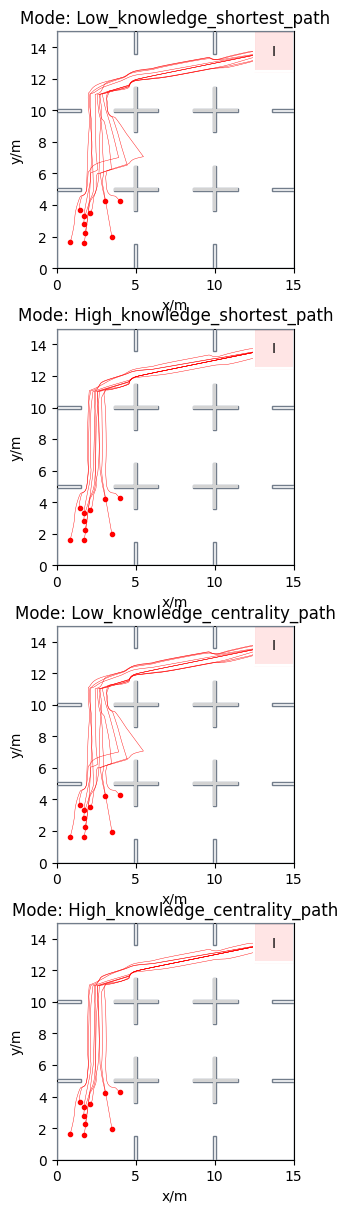

In [65]:
# Retrieve the boundary coordinates of the complete_area polygon
minx, miny, maxx, maxy = complete_area.bounds

# Create a figure with subplots arranged in a single column
# The number of rows is determined by the length of the 'modes' list
# Each subplot is assigned a height ratio of 5
# The overall figure size is set to 12 inches wide by 16 inches tall
fig, axes = plt.subplots(
    nrows=len(modes), ncols=1, height_ratios=[5] * len(modes),
    figsize=(12, 16)
)

# Ensure 'axes' is always an array, even if there's only one subplot
axes = np.atleast_1d(axes)

# Define a list of colors to differentiate agent groups in the plots
colors = ["red", "blue"]

# Iterate over each subplot axis and its corresponding mode
for ax, mode in zip(axes, agent_groups_per_mode):
    # Extract trajectory data for the current mode
    trajectories = agent_trajectories[mode].data

    # Initialize a list to hold groups of agents for the current mode
    list_of_groups = []

    # Populate the list with agent groups from each source
    for source in sources:
        list_of_groups.append(agent_groups_per_mode[mode][source].agents)

    # Iterate over each group of agents
    for ig, group in enumerate(list_of_groups):
        # Create a TrajectoryData object for the current group
        traj = pedpy.TrajectoryData(
            trajectories[trajectories["id"].isin(group)],
            frame_rate=agent_trajectories[mode].frame_rate,
        )

        # Plot the trajectories of the current group on the current axis
        pedpy.plot_trajectories(
            traj=traj,
            walkable_area=walkable_area,
            axes=ax,
            traj_color=colors[ig],
            traj_width=0.3,
            traj_start_marker=".",
        )

        # Set the title of the subplot to indicate the current mode
        ax.set_title(f"Mode: {modes_names[mode]}")

        # Set the x and y axis limits based on the complete_area boundaries
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # Ensure the aspect ratio is equal to maintain the scale of the plot
        ax.set_aspect('equal', adjustable='box')

    # Overlay exit polygons on the plot
    for name, exit_polygon in exit_polygons.items():
        # Extract the x and y coordinates of the polygon's exterior
        x, y = Polygon(exit_polygon).exterior.xy

        # Fill the polygon area with a semi-transparent red color
        ax.fill(x, y, alpha=0.1, color="red")

        # Outline the polygon with a white border
        ax.plot(x, y, color="white")

        # Calculate the centroid of the polygon
        centroid = Polygon(exit_polygon).centroid

        # Place the name of the exit at the centroid position
        ax.text(
            centroid.x, centroid.y, name, ha="center", va="center", fontsize=10
        )

# Adjust the layout to prevent overlapping elements
plt.tight_layout()

# Set the final size of the figure to 10 inches wide by 12 inches tall
fig.set_size_inches((10, 12))

# Display the figure with all subplots
plt.show()

## Calculate profiles

### Step 1: Compute individual speeds and Voronoi cells for each mode

In [66]:
individual_speed_per_mode = dict()
individual_voronoi_cells_per_mode = dict()

# Loop over each mode in the list of modes
for mode in modes:
    # Compute individual speed for the current mode
    individual_speed = pedpy.compute_individual_speed(
        traj_data=agent_trajectories[mode],
        frame_step=5,
        speed_calculation=pedpy.SpeedCalculation.BORDER_SINGLE_SIDED,
    )

    # Compute individual Voronoi polygons for the current mode
    individual_voronoi_cells = pedpy.compute_individual_voronoi_polygons(
        traj_data=agent_trajectories[mode],
        walkable_area=walkable_area,
        cut_off=pedpy.Cutoff(radius=0.8, quad_segments=3),
    )

    # Save the computed data into dictionaries keyed by mode
    individual_speed_per_mode[mode] = individual_speed
    individual_voronoi_cells_per_mode[mode] = individual_voronoi_cells

### Step 2: Compute density and speed profiles for each mode

In [67]:
# Define the frame range for profile computation
min_frame_profiles = 600
max_frame_profiles = 700

# Initialize dictionaries to store density and speed profiles per mode
density_profiles_per_mode = dict()
speed_profiles_per_mode = dict()

# Loop over each mode to calculate the profiles
for mode in modes:
    # Filter the Voronoi data for frames within the desired range
    voronoi_filtered = individual_voronoi_cells_per_mode[mode][
        individual_voronoi_cells_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Filter the speed data for frames within the desired range
    speed_filtered = individual_speed_per_mode[mode][
        individual_speed_per_mode[mode].frame.between(min_frame_profiles, max_frame_profiles)
    ]

    # Merge the filtered Voronoi and speed data on 'id' and 'frame'
    merged_data = pd.merge(
        voronoi_filtered,
        speed_filtered,
        on=["id", "frame"],
    )

    # Compute density and speed profiles using the merged data
    density_profiles, speed_profiles = pedpy.compute_profiles(
        individual_voronoi_speed_data=merged_data,
        walkable_area=walkable_area.polygon,
        grid_size=0.25,
        speed_method=pedpy.SpeedMethod.ARITHMETIC,
    )

    # Save the computed profiles in the corresponding dictionaries
    density_profiles_per_mode[mode] = density_profiles
    speed_profiles_per_mode[mode] = speed_profiles

### Step 3: Plot profiles with one row per mode and two columns per row
<div style="margin-left: 60px;"><h4>(first column: density, second column: speed)</h4></div>


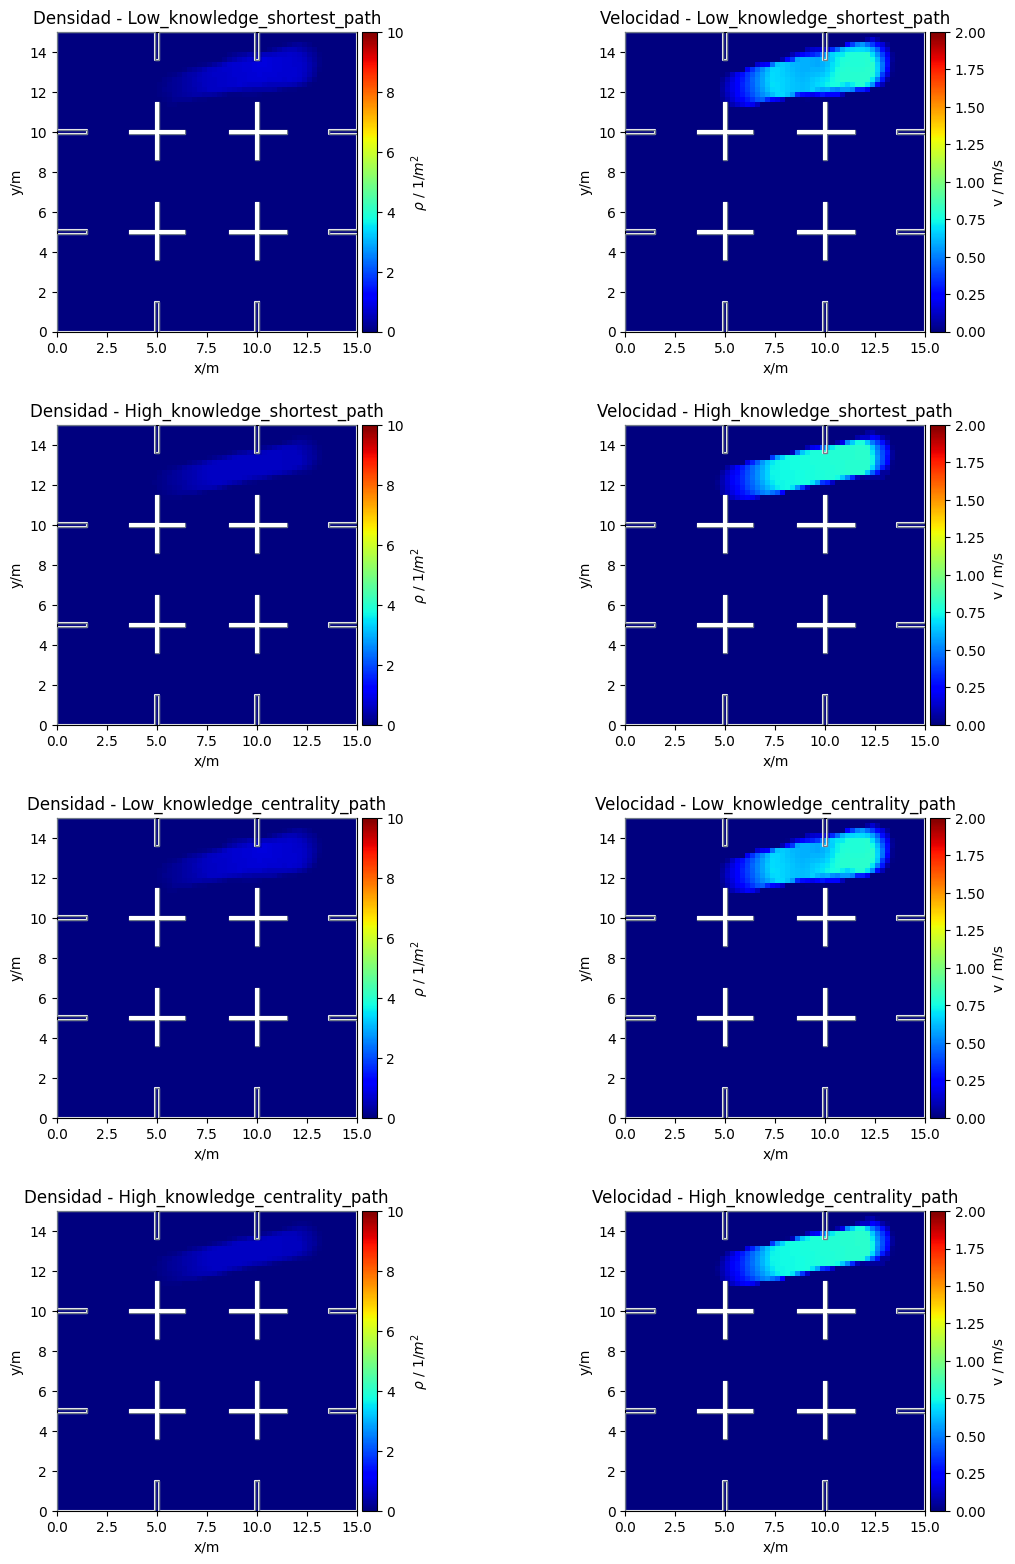

In [68]:
num_modes = len(modes)
fig, axes = plt.subplots(nrows=num_modes, ncols=2, figsize=(12, 4 * num_modes))

for idx, mode in enumerate(modes):
    # Seleccionamos el eje para densidad (columna 0) y para velocidad (columna 1)
    ax_density = axes[idx, 0]
    ax_speed = axes[idx, 1]

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=density_profiles_per_mode[mode],
        axes=ax_density,
        label="$\\rho$ / 1/$m^2$",
        vmin=0,
        vmax=10,
        title=f"Densidad - {modes_names[mode]}",
    )

    pedpy.plot_profiles(
        walkable_area=walkable_area,
        profiles=speed_profiles_per_mode[mode],
        axes=ax_speed,
        label="v / m/s",
        vmin=0,
        vmax=2,
        title=f"Velocidad - {modes_names[mode]}",
    )

fig.tight_layout(pad=2)
plt.show()

## Evacuation Times vs Mode

In [69]:
evac_times = []
for mode, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate # time equals frame / frame rate
    evac_times.append(t_evac)

for mode in modes:
    print(f"Mode: {modes_names[mode]}, time: {evac_times[mode]:2f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

Mode: Low_knowledge_shortest_path, time: 33.920000
Mode: High_knowledge_shortest_path, time: 33.440000
Mode: Low_knowledge_centrality_path, time: 33.920000
Mode: High_knowledge_centrality_path, time: 33.440000


## Risk vs Mode

In [70]:
avg_risk = {}

for mode in modes:
    try:
        with sqlite3.connect(agent_area_files[mode]) as agent_area_connection:
            avg_risk[mode] = get_average_risk(agent_area_connection)
    except Exception as e:
        print(f"Error processing mode {mode}: {e}")


for mode in modes:
    print(f"Mode: {modes_names[mode]}, risk: {avg_risk[mode]:.1f}")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(modes_names),
        y=list(avg_risk.values()),
        marker=dict(size=10),
        mode="lines+markers",
        name="Risks",
    )
)

fig.update_layout(
    title="Risks vs. Modes",
    xaxis_title="Mode",
    yaxis_title="Risks",
)

fig.show()

Mode: Low_knowledge_shortest_path, risk: 0.2
Mode: High_knowledge_shortest_path, risk: 0.3
Mode: Low_knowledge_centrality_path, risk: 0.2
Mode: High_knowledge_centrality_path, risk: 0.3
